# WordCloud Notebook

Membuat WordCloud dari kata-kata yang terdapat pada data

## 1. Import Libraries

Import library yang akan digunakan

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

## 2. Load Stopword

Menginput Stopword agar tidak ada Stopword yang masuk ke dalam WordCloud

In [2]:
# Create Stopword
with open("../kamus/Stopword.txt", "r") as f:
    stop_words = f.readline().split()

## 3. Load Data & Vectorizer

Load dataset hasil analisis dan vectorizer yang telah di fit sebelumnya

**Load Dataset**

In [3]:
# Import data
data = pd.read_csv('../data/Data Sentiment Twitter 19 - 27 April.csv')
data.head()

,Tanggal,Tweets,ID,Screen Name,Banyak Retweet,Source,Retweet Status,Hashtags,prediction
0,2020-04-27 23:59:57,bayangin kalo pabrik skincare tutup gara gara ...,1254923268621955072,vinnmuth,336,Twitter for Android,1,[],0
1,2020-04-27 23:59:57,wali kota palangkaraya positif jangkit virus c...,1254923270333231105,Nila_Widuri,4,Twitter for Android,1,"['TauCepatTanpaBatas', 'BeritaTerkini', 'Berit...",1
2,2020-04-27 23:59:56,perintah negara south wales australia pindah r...,1254923263584514048,nafisines,12,Twitter for iPhone,1,[],1
3,2020-04-27 23:59:52,proses pngmasan sahur msak taqi hilmi menu sah...,1254923248657035265,Tengsyut07,285,Twitter for Android,1,[],1
4,2020-04-27 23:59:49,anggota dapil pliiiiiiiiissss bantu jakarta daer,1254923236346720257,ChumaerohLaeli,665,Twitter Web App,1,[],2


Memisahkan index data yang bersentimen positif dan negatif

In [4]:
index_p = data['Tweets'][data['prediction'] == 2].index
index_n = data['Tweets'][data['prediction'] == 0].index

**Load Vectorizer**

In [5]:
# Load Model
import pickle
vectorizer_tfidf = pickle.load(open('../model/vectorizer/[TRAINED] TF-IDF Vectorizer.pickle', 'rb'))
word_tfidf = pickle.load(open('../model/vectorizer/word_tfidf.pickle', 'rb'))

**Nama Fitur**

Mengambil nama fitur / kata - kata yang terdapat pada vectorizer

In [6]:
# Fitur
nama_fitur = vectorizer_tfidf.get_feature_names()

## 4. Spesifikasi Kata Positif & Kata Negatif

Karena akan dibuat 2 WordCloud untuk kata Positif dan kata Negatif maka perlu menspesifikasikan kata Positif dan Negatif terlebih dahulu

In [7]:
# Select Positif & Negatif
positif = word_tfidf[index_p]
negatif = word_tfidf[index_n]

## 5. Mencari Kata Positif & Kata Negatif dengan Bobot Tertinggi

Karena jumlah kata yang ada sangat banyak maka akan dipilih kata dengan bobot tertinggi saja untuk ditampilkan kedalam WordCloud.

In [8]:
# Mencari Kata positif & Kata positif Dengan Bobot tertinggi
def finder(words):
    kata, top_kata = {}, {}
    for i in range(words.shape[0]):
        row = words.getrow(i).toarray()[0]
        max_ = max(row)
        for j in range(len(row)):
            if row[j] > 0:
                if nama_fitur[j] not in kata :
                    kata[nama_fitur[j]] = 1
                else :
                    kata[nama_fitur[j]] += 1
                if row[j] == max_:
                    if nama_fitur[j] in top_kata:
                        top_kata[nama_fitur[j]] += 1
                    else :
                        top_kata[nama_fitur[j]] = 1
    return kata, top_kata

In [9]:
positif, top_positif = finder(positif)
negatif, top_negatif = finder(negatif)

In [10]:
# Sorting
top_positif = {k: v for k, v in sorted(top_positif.items(), key=lambda item: item[1],reverse=True)}
top_negatif = {k: v for k, v in sorted(top_negatif.items(), key=lambda item: item[1],reverse=True)}

<h1>Membuat WordCloud</h1>
Membuat WordCloud untuk kata positif dan kata negatif.

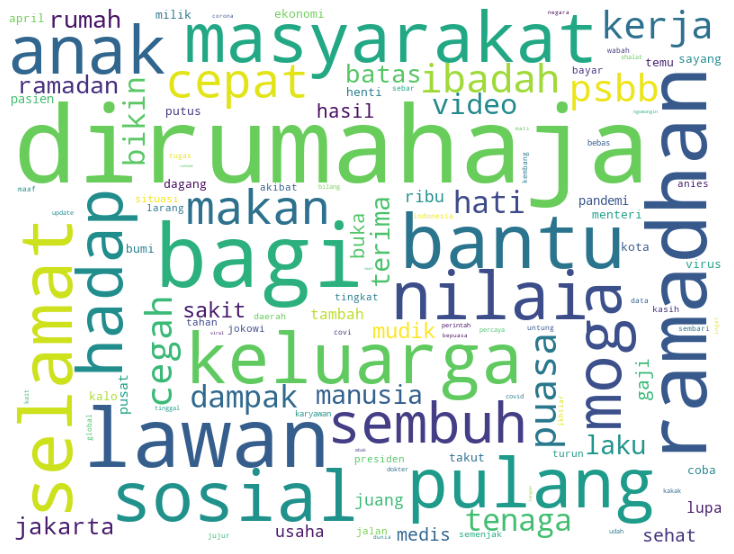

In [11]:
# WordCloud kata dengan bobot terbesar Positif
w = WordCloud(width=800,height=600,mode='RGBA',stopwords=stop_words,background_color='white',max_words=5000).fit_words(top_positif)
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(w)
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

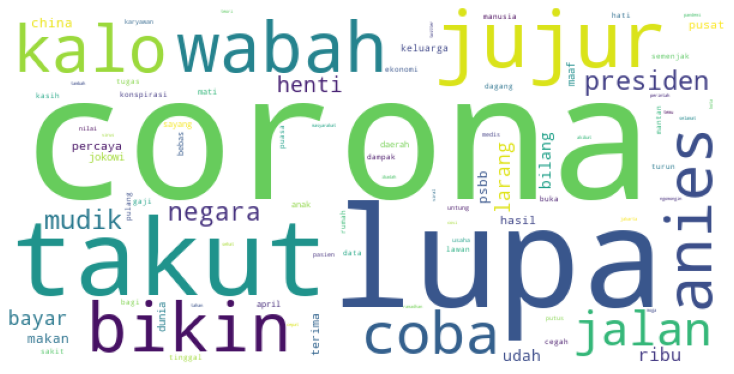

In [12]:
# WordCloud kata dengan bobot terbesar Negatif
w = WordCloud(width=600,height=300,mode='RGBA',stopwords=stop_words,background_color='white', max_words=5000).fit_words(top_negatif)
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(w)
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

<h1>Eksport Kata Kedalam Kamus</h1>
Eksport kata positif dan negatif kedalam Kamus

In [13]:
# Mengurangi duplikasi kata positif & negatif melalui perbandingan rasio kemunculan katanya
del_p, del_n = [], []
for kata in negatif.keys():
    if kata in positif:
        rasio_p = positif[kata]/sum(positif.values())
        rasio_n = negatif[kata]/sum(negatif.values())
        if rasio_p > rasio_n : 
            del_p.append(kata)
        else : 
            del_n.append(kata)
for i in del_p : 
    del positif[i]
for j in del_n : 
    del negatif[j]

# Sorting
kata_pos = sorted(positif.keys())
kata_neg = sorted(negatif.keys())

In [14]:
# Export Kata Positif & Kata Negatif
with open('../kamus/Kata Positif.txt','w') as p:
    p.write('\n'.join(kata_pos))

with open('../kamus/Kata Negatif.txt','w') as n:
    n.write('\n'.join(kata_neg))